In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
class ConvModel(Model):

    def __init__(self, input_shape=None):
        super(ConvModel, self).__init__()
        self.resnet = ResNet50(include_top=False, input_shape=input_shape)
        self.resnet.trainable = False
        self.flatten = Flatten()
        self.dense = Dense(512)
        self.bn = BatchNormalization()

    def call(self, input):

        x = self.resnet(input)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.bn(x)

        return x

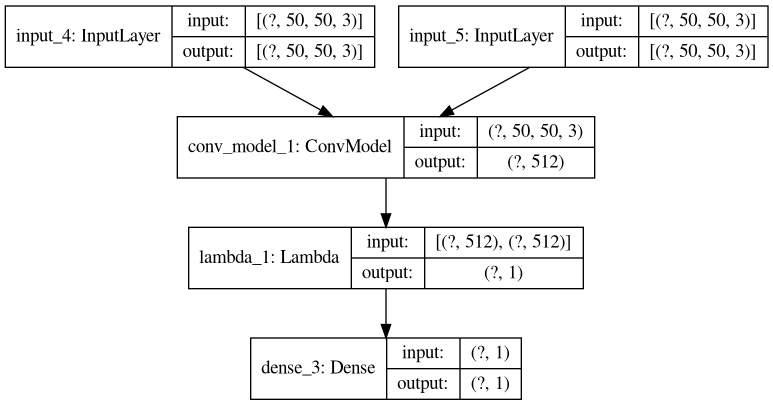

In [15]:
def calculate_distance(x):
    return K.sqrt(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True))


def distance_shape(shapes):
    shape1, _ = shapes
    return shape1[0], 1

def siamese(input_shape=None):

    left_image = Input(shape=input_shape)
    right_image = Input(shape=input_shape)

    conv_model = ConvModel(input_shape=input_shape)

    left_embedding = conv_model(left_image)
    right_embedding = conv_model(right_image)

    distance = Lambda(calculate_distance, output_shape=distance_shape)([left_embedding, right_embedding])
    pred = Dense(1, activation="sigmoid")(distance)

    model = Model(inputs=[left_image, right_image], outputs=pred)

    return model

model = siamese(input_shape=(50, 50, 3))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
plot_model(model, show_shapes=True)

In [4]:
from PIL import Image
import os
from pathlib import Path

IMAGE_DIR = Path("lfw")

def load_images():
    images = []
    names = []
    for d in os.listdir(IMAGE_DIR):
        for im in os.listdir(IMAGE_DIR/d):
            with Image.open(IMAGE_DIR/d/im) as image:
                image = image.resize((50, 50))
                images.append(list(np.array(image) / 255.))
                names.append(d)

    return images, names

images, names = load_images()

In [5]:
from sklearn.model_selection import train_test_split

images = np.array(images)
names = np.array(names)
X_train, X_test, y_train, y_test = train_test_split(images, names, test_size=.2)

del images
del names

In [6]:
def create_pairs(images, names):
    
    pairs = []
    labels = []
    
    uniq_faces = np.unique(names)
    idx = {i: np.where(names == i)[0] for i in uniq_faces}
    
    for i in range(len(images)):
        im1 = images[i]
        name = names[i]
        
        # Positive pair
        j = np.random.choice(idx[name])
        im2 = images[j]
        
        pairs.append([im1, im2])
        labels.append(1)
        
        # Negative pair
        k = np.where(names != name)[0]
        im3 = images[np.random.choice(k)]
        
        pairs.append([im1, im3])
        labels.append(0)
        
    return np.array(pairs), np.array(labels)
        

train_pairs, train_labels = create_pairs(X_train, y_train)
test_pairs, test_labels = create_pairs(X_test, y_test)

del X_train, y_train, X_test, y_test

Different person


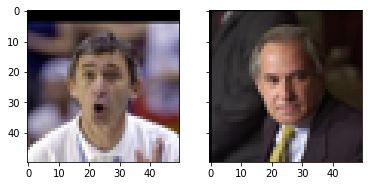

In [7]:
idx = np.random.randint(0, len(train_pairs))
example_pair = train_pairs[idx]
example_label = "Same person" if train_labels[idx] == 1 else "Different person"

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].imshow(example_pair[0])
axs[1].imshow(example_pair[1])
print(example_label)

In [8]:
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, epochs=50, batch_size=200)

Epoch 1/50
106/106 [==============================] - 27s 258ms/step - loss: 0.9846 - accuracy: 0.4334
Epoch 2/50
106/106 [==============================] - 26s 241ms/step - loss: 0.7003 - accuracy: 0.4313
Epoch 3/50
106/106 [==============================] - 26s 242ms/step - loss: 0.6670 - accuracy: 0.5000
Epoch 4/50
106/106 [==============================] - 26s 242ms/step - loss: 0.6472 - accuracy: 0.6094
Epoch 5/50
106/106 [==============================] - 26s 242ms/step - loss: 0.6287 - accuracy: 0.7300
Epoch 6/50
106/106 [==============================] - 26s 242ms/step - loss: 0.6115 - accuracy: 0.7318
Epoch 7/50
106/106 [==============================] - 26s 243ms/step - loss: 0.5974 - accuracy: 0.7339
Epoch 8/50
106/106 [==============================] - 26s 242ms/step - loss: 0.5844 - accuracy: 0.7375
Epoch 9/50
106/106 [==============================] - 26s 242ms/step - loss: 0.5728 - accuracy: 0.7413
Epoch 10/50
106/106 [==============================] - 26s 241ms/step - l

In [9]:
_, acc = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(acc*100)

166/166 [==============================] - 10s 63ms/step - loss: 0.3898 - accuracy: 0.8147
81.46958947181702


In [17]:
model.save_weights("siamese.h5")

In [12]:
train_pairs.shape

(21172, 2, 50, 50, 3)

In [25]:
print(names)

 'Ariel_Sharon', 'Ariel_Sharon', 'Ariel_Sharon', 'Ariel_Sharon', 'Ariel_Sharon', 'Ariel_Sharon', 'Anastasia_Kelesidou', 'Miyako_Miyazaki', 'Miyako_Miyazaki', 'Frank_Bell', 'Joseph_Ganim', 'Jane_Russell', 'James_Watt', 'Zach_Pillar', 'Silvio_Fernandez', 'Silvio_Fernandez', 'Gen_Meredith', 'Razali_Ismail', 'Valentina_Tereshkova', 'Buck_Rodgers', 'Roger_Cook', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_Putin', 'Vladimir_